<h1>Limpar aquivos 1k, 5k, 100k</h1>

<h2>Analisar estrutura de um tweet</h2>

In [1]:
import pandas as pd

tab_1 = pd.read_json('1_tweet.json',lines=True,convert_dates=False)
tab_1

,_id,quote_count,contributors,truncated,text,is_quote_status,in_reply_to_status_id,reply_count,id,favorite_count,...,geo,in_reply_to_user_id_str,possibly_sensitive,lang,extended_tweet,created_at,filter_level,in_reply_to_status_id_str,place,control
0,{'$numberLong': '1240986591545393153'},0,NaN,True,Covid-19: quem vai colher os erros de Bolsonar...,False,NaN,0,{'$numberLong': '1240986591545393153'},0,...,NaN,NaN,False,pt,"{'display_text_range': [0, 223], 'entities': {...",{'$date': '2020-03-19T10:00:34.000-0300'},low,NaN,NaN,{'coleta': [439]}


In [2]:
tab_1['user']

0    {'follow_request_sent': None, 'profile_use_bac...
Name: user, dtype: object

<h2>Criar arquivo com tweets por usuário por dia</h2>

In [24]:
import nltk
import re
import pandas as pd
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
from string import punctuation

#stopwords em portugues
from nltk.corpus import stopwords
stopwords = set(stopwords.words('portuguese') + list(punctuation) + ['“','”'])

#funçao pra limpeza de texto
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)

In [4]:
#funçao pra leitura de dados e criaçao de dataframe
def json_to_dataframe(nome_json, colunas, chunk=30):
    dados = pd.read_json(nome_json, convert_dates = False, lines = True, chunksize = chunk)    
    
    for df_tweets_retweets in dados:
        yield df_tweets_retweets[colunas]

In [5]:
#funçao pra limpar texto e retirar stopwords
def tokenizar_texto(texto_tweet):
    texto_tokenizado = tweet_tokenizer.tokenize(texto_tweet)

    if texto_tokenizado[0] == "rt" and texto_tokenizado[1] == ":":
        del texto_tokenizado[0]
    
    palavras_sem_stopwords = [palavra for palavra in texto_tokenizado if palavra not in stopwords] 
    return palavras_sem_stopwords

In [6]:
#funçao pra criar dicionario com a data e quantidade dos tweets por usuario
def contagem_usuarios_data(gerador,destino):
    
    dict_datas_usuarios = defaultdict(dict)            
    
    for dataframe in gerador:        
        for linha in dataframe.values:            
            usuario = linha[0]['screen_name']

            data = linha[1]['$date'][:10]
            if data not in dict_datas_usuarios or usuario not in dict_datas_usuarios[data]:
                dict_datas_usuarios[data][usuario] = 0
            dict_datas_usuarios[data][usuario] += 1
            clear_output()
            
    escrever_arq_csv(dict_datas_usuarios,destino)

In [7]:
#funçao pra escrever os resultados no arquivo csv
def escrever_arq_csv(dict_datas_usuarios,destino):
    with open(destino, 'w', encoding="utf-8") as f:
        f.write("Datas;Usuários;Tweets\n")

        for key in dict_datas_usuarios.keys():
            for user in dict_datas_usuarios[key].keys():
                f.write("%s;%s;%s\n"%(key, user, dict_datas_usuarios[key][user]))
            
    print('A contagem de tweets por usuario por data foi salva com sucesso no arquivo')

In [8]:
#execuçao do codigo
#1k
gerador = json_to_dataframe('1k_origin.json',["user","created_at"])

contagem_usuarios_data(gerador,'cont_usuarios_data_1k.csv')

A contagem de tweets por usuario por data foi salva com sucesso no arquivo


In [9]:
#5k
gerador = json_to_dataframe('5k_origin.json',["user","created_at"])

contagem_usuarios_data(gerador,'cont_usuarios_data_5k.csv')

A contagem de tweets por usuario por data foi salva com sucesso no arquivo


In [10]:
#100k
gerador = json_to_dataframe('100k_origin.json',["user","created_at"])

contagem_usuarios_data(gerador,'cont_usuarios_data_100k.csv')

A contagem de tweets por usuario por data foi salva com sucesso no arquivo


<h2>Fazer análises com arquivo gerado</h2>

<h3>Resultar análise do número de usuarios</h3>
<p>(Exibir analises em forma gráfica para cada arquivo)</p>

In [77]:
cont_usuarios_data = pd.read_csv('cont_usuarios_data_100k.csv', sep = ";")
cont_usuarios_data.head()

,Datas,Usuários,Tweets
0,2020-03-20,Naaclara0,1
1,2020-03-20,arcanjoOficial,1
2,2020-03-20,R_Ramba09,1
3,2020-03-20,RhysandAaron,1
4,2020-03-20,capartensucette,1


In [141]:
# nUMERO DE USUARIOS POR DATA
usuarios_por_data = cont_usuarios_data.groupby('Datas')['Usuários'].apply(len)
usuarios_por_data

Datas
2020-03-20    75820
Name: Usuários, dtype: int64

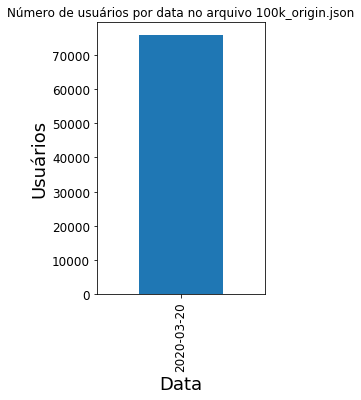

In [158]:
import matplotlib.pyplot as plt
grafico_barras = usuarios_por_data.plot(kind='bar', title ="Número de usuários por data no arquivo 100k_origin.json",figsize=(3,5),legend=False, fontsize=12)
grafico_barras.set_ylabel("Usuários",fontsize=18)
grafico_barras.set_xlabel("Data",fontsize=18)

plt.show()


In [159]:
# NUMERO DE TWEETS POR DATA
tweets_por_data = cont_usuarios_data.groupby('Datas')['Tweets'].apply(sum)
tweets_por_data

Datas
2020-03-20    100000
Name: Tweets, dtype: int64

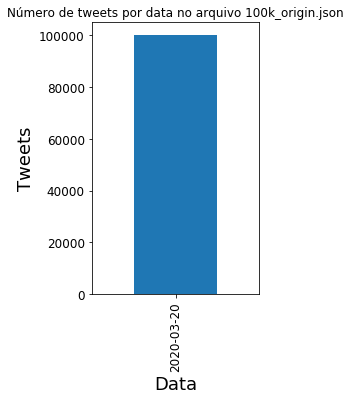

In [178]:
grafico_barras = tweets_por_data.plot(kind='bar', title ="Número de tweets por data no arquivo 100k_origin.json",figsize=(3,5),legend=False, fontsize=12)
grafico_barras.set_ylabel("Tweets",fontsize=18)
grafico_barras.set_xlabel("Data",fontsize=18)

plt.show()


In [187]:
tweets = pd.DataFrame(tweets_por_data.copy())
tweets['Usuários'] = usuarios_por_data
tweets.reset_index(inplace=True)
tweets

,Datas,Tweets,Usuários
0,2020-03-20,100000,75820


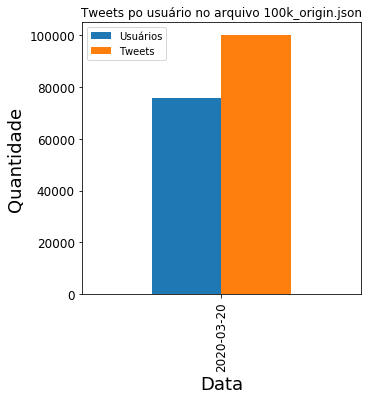

In [190]:
grafico_barras = tweets.plot(x ='Datas', y=['Usuários','Tweets'], kind='bar', title ="Tweets po usuário no arquivo 100k_origin.json",figsize=(5,5),legend=True, fontsize=12)
grafico_barras.set_xlabel("Data",fontsize=18)
grafico_barras.set_ylabel("Quantidade",fontsize=18)

plt.yscale("linear")
plt.show()

In [82]:
# TOP 15 USUARIOS QUE MAIS TWEETARAM NO GERAL
TOP15 = cont_usuarios_data.groupby('Usuários')['Tweets'].apply(sum).sort_values(ascending = False)[:15]
TOP15

Usuários
JornalDestak       80
gabieesteves       68
CoronaBotBR        53
MargaretteBras5    36
tadeu_alves        35
0Lake4             33
PrWilsonMartins    33
pedrobittar        33
ptribeirao         32
TellesCelso        32
Ary_AntiPT         31
___DENISE___EU_    31
gojammaj           31
tovaga             30
croismo            29
Name: Tweets, dtype: int64

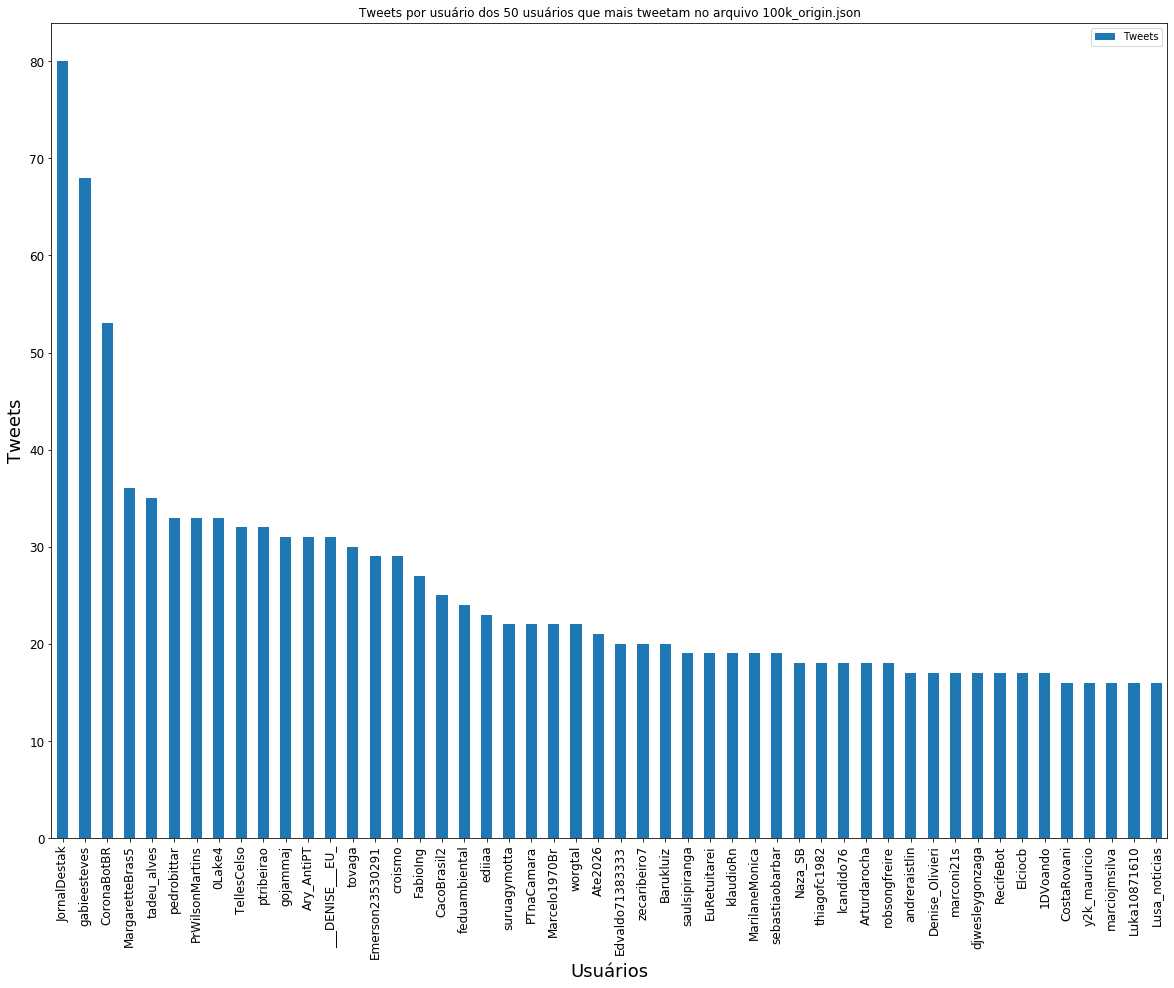

In [253]:
grafico_barras = cont[:50].plot(x ='Usuários', y='Tweets', kind='bar', title ="Tweets por usuário dos 50 usuários que mais tweetam no arquivo 100k_origin.json",figsize=(20,15),legend=True, fontsize=12)
grafico_barras.set_xlabel("Usuários",fontsize=18)
grafico_barras.set_ylabel("Tweets",fontsize=18)

plt.show()

In [247]:
cont = cont_usuarios_data.set_index('Usuários').sort_values('Tweets', ascending = False).reset_index()
cont.head()

,Usuários,Datas,Tweets
0,JornalDestak,2020-03-20,80
1,gabieesteves,2020-03-20,68
2,CoronaBotBR,2020-03-20,53
3,MargaretteBras5,2020-03-20,36
4,tadeu_alves,2020-03-20,35


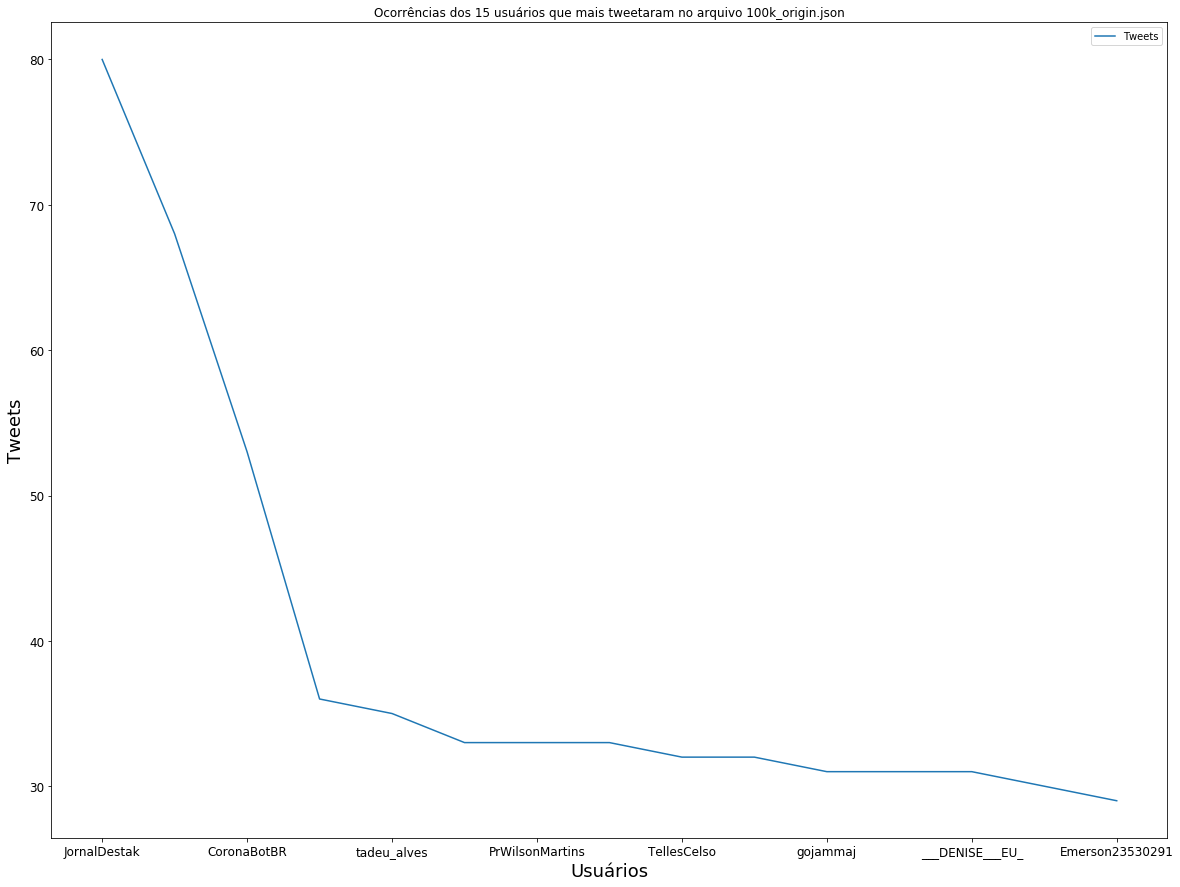

In [252]:
grafico_barras = cont[:15].plot(x ='Usuários', y='Tweets',kind='line', title ="Ocorrências dos 15 usuários que mais tweetaram no arquivo 100k_origin.json",figsize=(20,15),legend=True, fontsize=12)
grafico_barras.set_xlabel("Usuários",fontsize=18)
grafico_barras.set_ylabel("Tweets",fontsize=18)

plt.show()

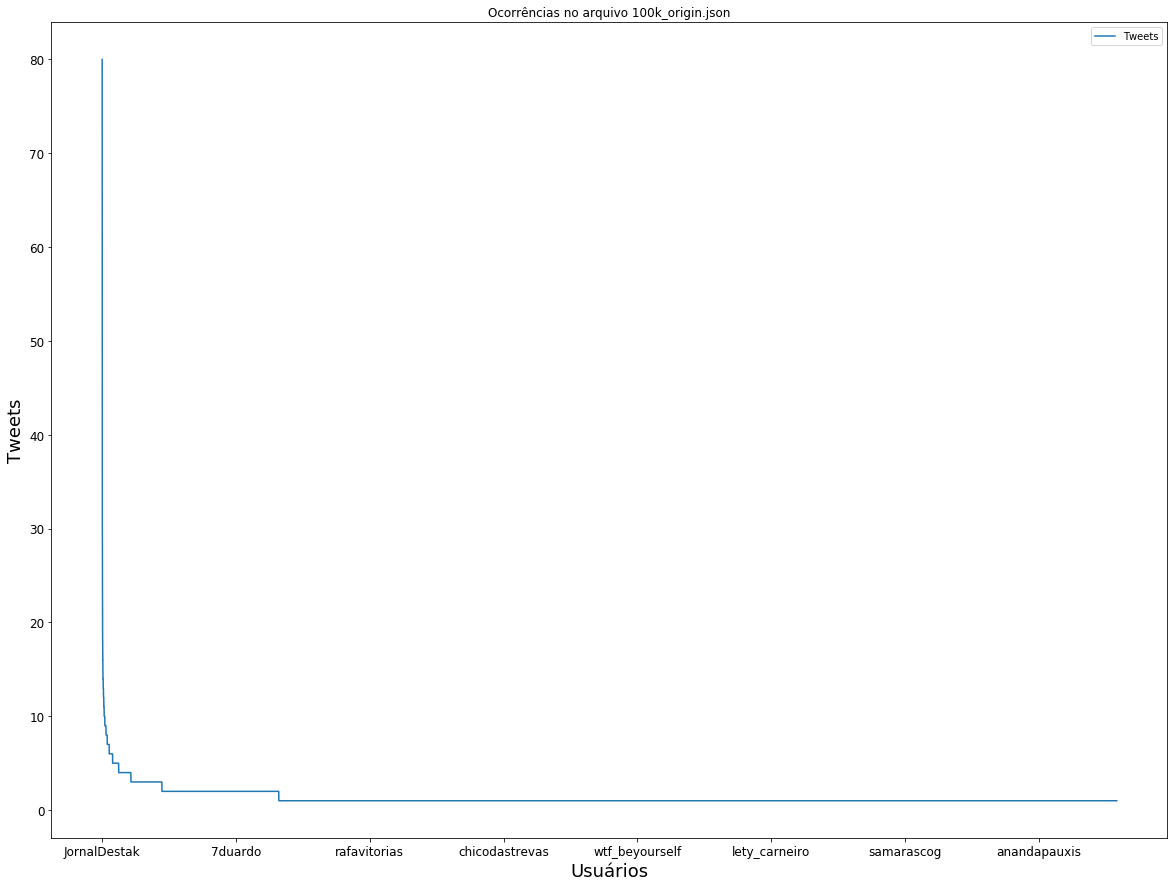

In [215]:
grafico_barras = cont.plot(x ='Usuários', y='Tweets',kind='line', title ="Ocorrências no arquivo 100k_origin.json",figsize=(20,15),legend=True, fontsize=12)
grafico_barras.set_xlabel("Usuários",fontsize=18)
grafico_barras.set_ylabel("Tweets",fontsize=18)

plt.show()